# Feature Extraction Methods - Exploration


- Author: Elmo Chavez
- Date: 15-Jun-2023


## Read the Dataset


Libraries


In [1]:
import mne 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from tkinter import Tk
from tkinter.filedialog import askdirectory

root = Tk()
root.withdraw()

path = askdirectory()

root.quit()
root.destroy()

2023-08-06 22:38:28.461 python[38616:710860] +[CATransaction synchronize] called within transaction


In [3]:
path_der_sub001 = path+'/derivatives/sub-002/eeg/'
filename = 'sub-002_task-eyesclosed_eeg.set'

raw = mne.io.read_raw_eeglab(path_der_sub001+filename, preload=True, verbose='CRITICAL')
raw

<RawEEGLAB | sub-002_task-eyesclosed_eeg.set, 19 x 396550 (793.1 s), ~57.5 MB, data loaded>

In [4]:
raw.get_data().shape

(19, 396550)

In [5]:
sfreq = raw.info['sfreq']

start_time = 0
end_time = 600

duration = 60.0
overlapping = 20.0

epochs = mne.make_fixed_length_epochs(raw.copy().crop(tmin=start_time, tmax=end_time),
                                    duration=duration, overlap=overlapping, preload=True, verbose='CRITICAL')

epochs

Number of events,14
Events,1: 14
Time range,0.000 – 59.998 s
Baseline,off


In [6]:
# Epochs, Channels, Points
epochs.get_data().shape

(14, 19, 30000)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


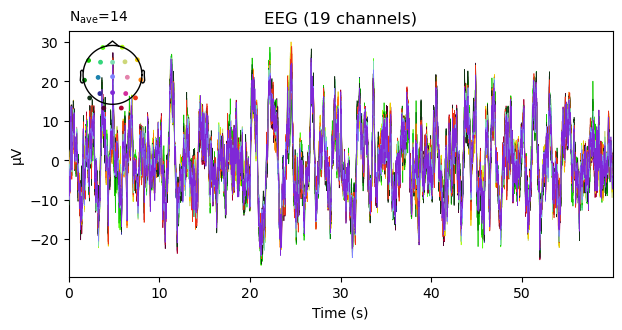

In [7]:
fig = epochs.average().plot()
plt.show()

# Feature Extraction Methods


## Statistic Approach


In [8]:
from scipy.stats import skew, kurtosis

In [9]:
epochs_data = epochs.get_data()

ch_mean = np.mean(epochs_data,axis=(0,2))
ch_var = np.var(epochs_data, axis=(0,2))
ch_ptp = np.ptp(epochs_data, axis=(0,2))
ch_skew = skew(epochs_data, axis=(0,2))
ch_kurtosis = kurtosis(epochs_data, axis=(0,2))

In [10]:
# Concatenate by having mean for all channets, var for all channels, and so on.
#stat_features = np.concatenate((ch_mean, ch_var, ch_ptp, ch_skew, ch_kurtosis), axis=0)

# Concatenate by intercalating metrics for each channel.
stat_features = np.column_stack((ch_mean.reshape(1, -1), 
                                 ch_var.reshape(1, -1), 
                                 ch_ptp.reshape(1, -1), 
                                 ch_skew.reshape(1, -1), 
                                 ch_kurtosis.reshape(1, -1)))

# Shape (19*5) Channels * Metrics
stat_features.shape

(1, 95)

## Time Frequency Domain


In [11]:
from mne.time_frequency import tfr_multitaper, tfr_morlet

#### TFR Multitaper Method


Frequencies: Get the center frequency from all the Bands (Delta, Theta, Alpha, Beta & Gamma)


In [12]:
# Frequency Bands
frequency_bands = {'delta': (0.5, 4),
                   'theta': (4, 8),
                   'alpha': (8, 13),
                   'beta': (13, 30),
                   'gamma': (30, 45)}

# Centers
bands = []
frequencies = []
for key, value in frequency_bands.items():
    center = np.mean(value)
    bands.append(key)
    frequencies.append(center)
    
print(bands)
print(frequencies)

['delta', 'theta', 'alpha', 'beta', 'gamma']
[2.25, 6.0, 10.5, 21.5, 37.5]


Get the power on each frequency with TFR_Multitaper from MNE


In [13]:
n_cycles = 5
frequencies = np.arange(1, 46, 1)
print('Number of Frequencies:',len(frequencies))

tfr = tfr_multitaper(epochs, freqs=frequencies, n_cycles=n_cycles, return_itc=False, verbose=None)
tfr.data.shape

Number of Frequencies: 45


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   25.7s finished


(19, 45, 30000)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


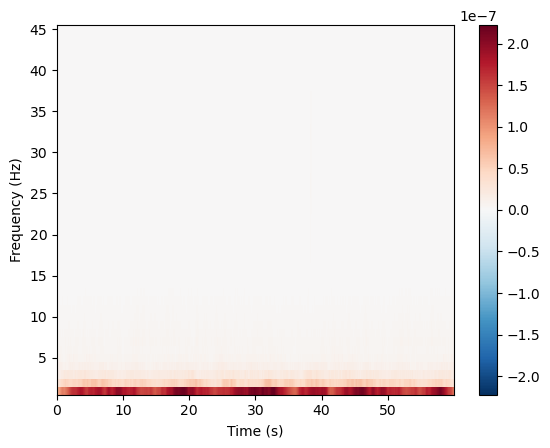

In [14]:
fig = tfr.copy().pick(['Fp1']).plot()
plt.show()

In [15]:
# Calculate features for each channel
features = [np.mean(tfr.data, axis=(1,2)), 
            np.std(tfr.data, axis=(1,2)), 
            np.var(tfr.data, axis=(1,2)), 
            np.ptp(tfr.data, axis=(1,2)), 
            skew(tfr.data, axis=(1,2)), 
            kurtosis(tfr.data, axis=(1,2))]

tfr_features = np.column_stack([feat.reshape(1,-1) for feat in features])
tfr_features.shape

(1, 114)

In [16]:
tfr_features[0].shape

(114,)

Plot Results from TFR and Metrics


### TFR Morlet Transform Method


In [17]:
tfr_2 = tfr_morlet(epochs, frequencies, n_cycles, return_itc=False, verbose='critical')

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


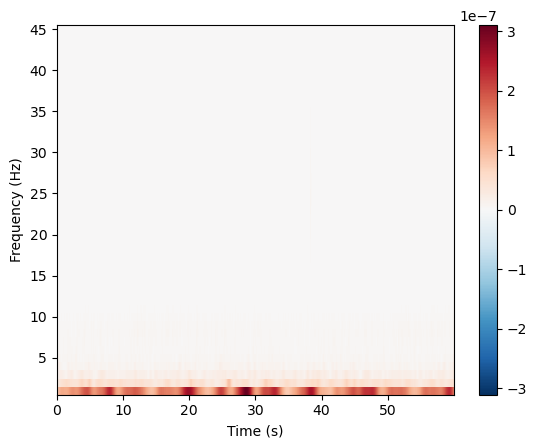

In [18]:
fig = tfr_2.copy().pick(['Fp1']).plot()
plt.show()

In [19]:
tfr_2.data.shape

(19, 45, 30000)

In [20]:
# Calculate features for each channel
features2 = [np.mean(tfr.data, axis=(1,2)), 
            np.std(tfr.data, axis=(1,2)), 
            np.var(tfr.data, axis=(1,2)), 
            np.ptp(tfr.data, axis=(1,2)), 
            skew(tfr.data, axis=(1,2)), 
            kurtosis(tfr.data, axis=(1,2))]

tfr_features2 = np.column_stack([feat.reshape(1,-1) for feat in features2])
tfr_features2.shape

(1, 114)

## Frequency Domain


### PSD


In [9]:
spectrum = epochs.compute_psd(method='multitaper', fmin=0.5, fmax=45, tmin=0.0, tmax=60.0, verbose='critical')

Averaging across epochs...


/Users/sobieddch/opt/anaconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


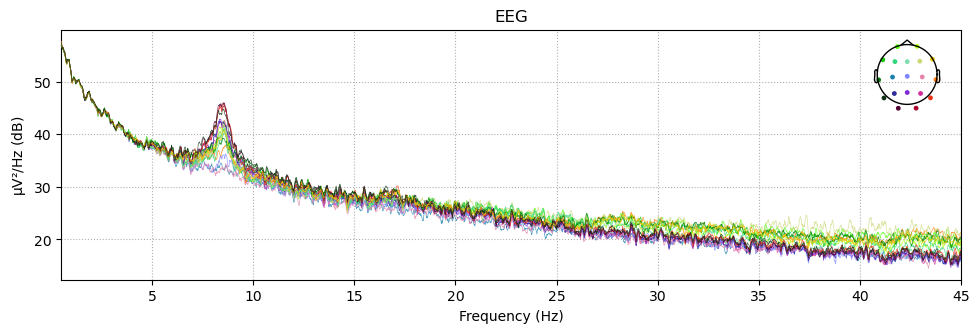

In [10]:
fig = spectrum.plot(picks='data',exclude='bads')
plt.show()

In [11]:
mean_spectrum = spectrum.average()
psds = mean_spectrum.get_data(return_freqs=False)
psds.shape

(19, 2671)

In [12]:
ch_names = epochs.ch_names

psd_features = []
psd_features.append(np.mean(psds, axis=1))
psd_features.append(np.std(psds, axis=1))
psd_features.append(np.var(psds, axis=1))
psd_features.append(np.ptp(psds, axis=1))
psd_features.append(skew(psds, axis=1))
psd_features.append(kurtosis(psds, axis=1))

In [17]:
psd_features[0]

array([7.13185793e-09, 7.17306232e-09, 7.10734244e-09, 7.18859607e-09,
       6.93676375e-09, 6.89056381e-09, 7.36895037e-09, 7.27880741e-09,
       7.83609262e-09, 7.71590362e-09, 7.62944027e-09, 7.27311652e-09,
       7.41454449e-09, 7.17490260e-09, 7.78588552e-09, 7.75607024e-09,
       7.11484809e-09, 7.00234845e-09, 7.31811544e-09])

In [16]:
np.concatenate(psd_features)

array([7.13185793e-09, 7.17306232e-09, 7.10734244e-09, 7.18859607e-09,
       6.93676375e-09, 6.89056381e-09, 7.36895037e-09, 7.27880741e-09,
       7.83609262e-09, 7.71590362e-09, 7.62944027e-09, 7.27311652e-09,
       7.41454449e-09, 7.17490260e-09, 7.78588552e-09, 7.75607024e-09,
       7.11484809e-09, 7.00234845e-09, 7.31811544e-09, 3.69306112e-08,
       3.74906756e-08, 3.73298888e-08, 3.74478182e-08, 3.77431925e-08,
       3.76105333e-08, 3.78248764e-08, 3.77633889e-08, 3.83637447e-08,
       3.83600869e-08, 3.90794948e-08, 3.77910299e-08, 3.77327546e-08,
       3.76036376e-08, 3.80332401e-08, 3.82909211e-08, 3.73648379e-08,
       3.79320134e-08, 3.79899988e-08, 1.36387005e-15, 1.40555076e-15,
       1.39352060e-15, 1.40233909e-15, 1.42454858e-15, 1.41455222e-15,
       1.43072127e-15, 1.42607354e-15, 1.47177691e-15, 1.47149627e-15,
       1.52720691e-15, 1.42816194e-15, 1.42376077e-15, 1.41403356e-15,
       1.44652736e-15, 1.46619464e-15, 1.39613111e-15, 1.43883764e-15,
      

/var/folders/42/zkw31xg11x1f6dpl9zz6hmz00000gn/T/ipykernel_14237/3102238945.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ch_names)


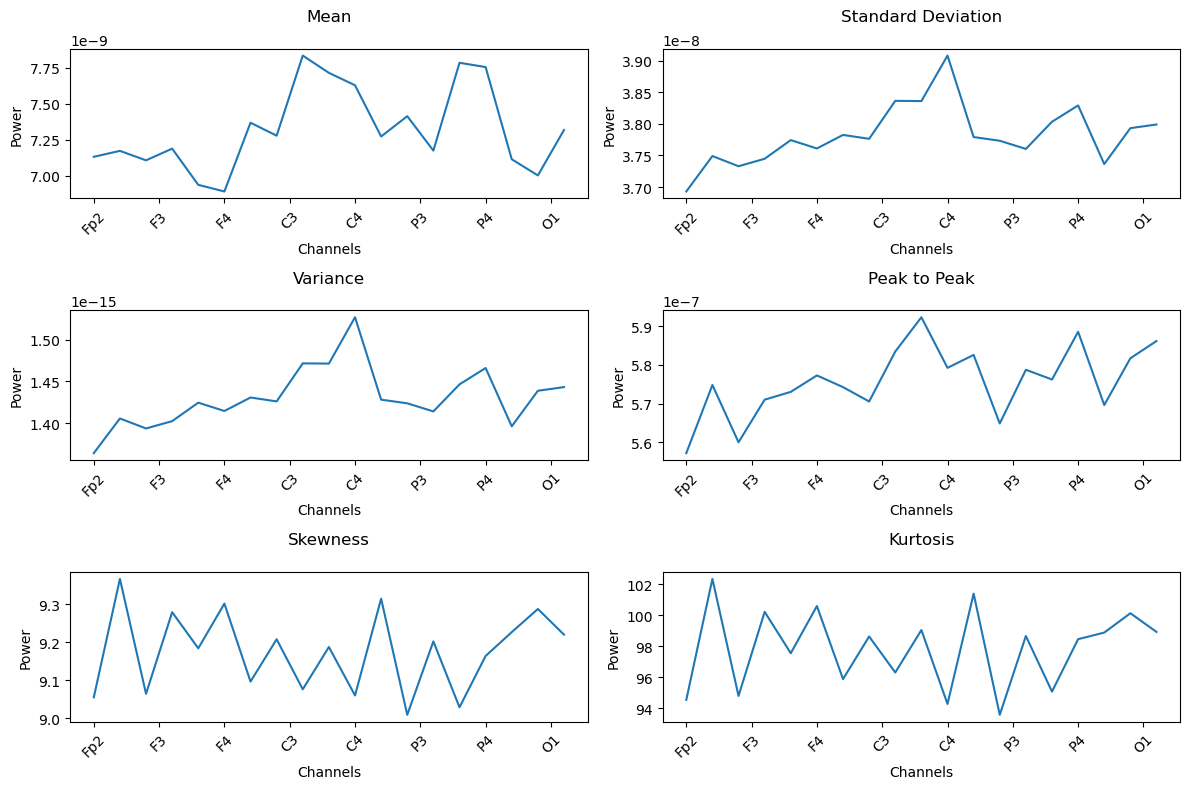

In [28]:
metrics = ['Mean', 'Standard Deviation','Variance','Peak to Peak','Skewness','Kurtosis']
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

for i, ax in enumerate(axs.flat):
    ax.plot(psd_features[i])
    ax.set_xlabel('Channels')
    ax.set_ylabel('Power')
    ax.set_xticklabels(ch_names)
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(metrics[i], pad=20)

plt.tight_layout()
plt.show()

In [9]:
import features_eeg as feeg

psd_feat, columns = feeg.PSD_Features(epochs.copy().pick(['Fp1']), fmin=1, fmax=45.0)
print(psd_feat.shape, len(columns))

(6,) 6


In [10]:
columns

[('Fp1_mean', 'float'),
 ('Fp1_standard_deviation', 'float'),
 ('Fp1_variance', 'float'),
 ('Fp1_peak_to_peak', 'float'),
 ('Fp1_skewness', 'float'),
 ('Fp1_kurtosis', 'float')]